In [1]:
%load_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
from matplotlib import cm

In [3]:
# Set plotting style
plt.style.use("seaborn-v0_8-white")

LINE_COLOR = "purple"

# Metadata saved to output plots
METADATA = {"Contributor": "Alexander Gude", "Rights": "CC-BY-SA 4.0"}

In [4]:
%matplotlib inline

In [5]:
# Show all columns
pd.set_option("display.max_columns", None)

In [6]:
START_YEAR = 2001
LAST_YEAR = 2020

SQL_FILE = "./v2.0.0-converted_with_sts_v4.0.0-switrs.sqlite"

In [7]:
# Date conversion function
def date_columns(query):
    """If a date column is included in the query, parse it as a date in the
    dataframe."""
    dates = []
    fields = ["collision_date", "process_date"]
    if "*" in query:
        dates = fields
    else:
        for date in fields:
            if date in query:
                dates.append(date)

        if not dates:
            dates = None

    return dates

In [8]:
# We should be able to just set rcParams, expect Jupyter has a bug:
# https://github.com/jupyter/notebook/issues/3385
#
# So we have to call this function every time we want to plot.


def setup_plot(title=None, xlabel=None, ylabel=None):
    """Set up a simple, single pane plot with custom configuration.

    Args:
        title (str, optional): The title of the plot.
        xlabel (str, optional): The xlabel of the plot.
        ylabel (str, optional): The ylabel of the plot.

    Returns:
        (fig, ax): A Matplotlib figure and axis object.

    """
    # Plot Size
    plt.rcParams["figure.figsize"] = (12, 7)  # (Width, height)

    # Text Size
    SMALL = 12
    MEDIUM = 16
    LARGE = 20
    HUGE = 28
    plt.rcParams["axes.titlesize"] = HUGE
    plt.rcParams["figure.titlesize"] = HUGE
    plt.rcParams["axes.labelsize"] = LARGE
    plt.rcParams["legend.fontsize"] = LARGE
    plt.rcParams["xtick.labelsize"] = MEDIUM
    plt.rcParams["ytick.labelsize"] = MEDIUM
    plt.rcParams["font.size"] = SMALL

    # Legend
    plt.rcParams["legend.frameon"] = True
    plt.rcParams["legend.framealpha"] = 1
    plt.rcParams["legend.facecolor"] = "white"
    plt.rcParams["legend.edgecolor"] = "black"

    # Figure output
    plt.rcParams["savefig.dpi"] = 300

    # Make the plol
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    return fig, ax

In [9]:
def save_plot(fig, filename):
    """Save the plot with metadata and tight layout.

    Args:
        fig (matplotlib figure): The figure to save.
        filename (str): The loction to save the file to.

    """
    metadata = METADATA

    fig.savefig(
        fname=f"{filename}",
        bbox_inches="tight",
        metadata=metadata,
    )

# Crashes by Week

Let's start by looking at the number of incidents per month:

In [10]:
query = (
    "SELECT collision_date, collision_time, pedestrian_killed_count "
    "FROM collisions "
    "WHERE Collision_Date IS NOT NULL "
    f"AND Collision_Date <= '{LAST_YEAR}-12-31' "
    "AND pedestrian_Collision = 1 "
    "ORDER BY collision_date"
)


with sqlite3.connect(SQL_FILE) as con:
    df = pd.read_sql(
        query,
        con,
        parse_dates=["collision_date", "collision_time"],
    )

In [11]:
DATE_COL = "collision_date"
CRASH_COL = "crashes"

df["day_of_year"] = df[DATE_COL].dt.dayofyear
df["day_of_week"] = df[DATE_COL].dt.dayofweek
df["day"] = df[DATE_COL].dt.day
df["week"] = df[DATE_COL].dt.isocalendar().week
df["month"] = df[DATE_COL].dt.month
df["year"] = df[DATE_COL].dt.year
df["hour"] = df["collision_time"].dt.hour
df["is_weekend"] = df["day_of_week"].isin([5, 6])
df[CRASH_COL] = 1

In [12]:
df.head()

,collision_date,collision_time,pedestrian_killed_count,day_of_year,day_of_week,day,week,month,year,hour,is_weekend,crashes
0,2001-01-01,2022-11-09 10:30:00,0,1,0,1,1,1,2001,10.0,False,1
1,2001-01-01,2022-11-09 14:22:00,0,1,0,1,1,1,2001,14.0,False,1
2,2001-01-01,2022-11-09 15:02:00,0,1,0,1,1,1,2001,15.0,False,1
3,2001-01-01,2022-11-09 12:49:00,0,1,0,1,1,1,2001,12.0,False,1
4,2001-01-01,NaT,0,1,0,1,1,1,2001,NaN,False,1


In [13]:
ts = df[[DATE_COL]]
ts.index = ts[DATE_COL]

ts_series = ts.resample("M").count()[DATE_COL]
x = ts_series.index.values
y = ts_series.values

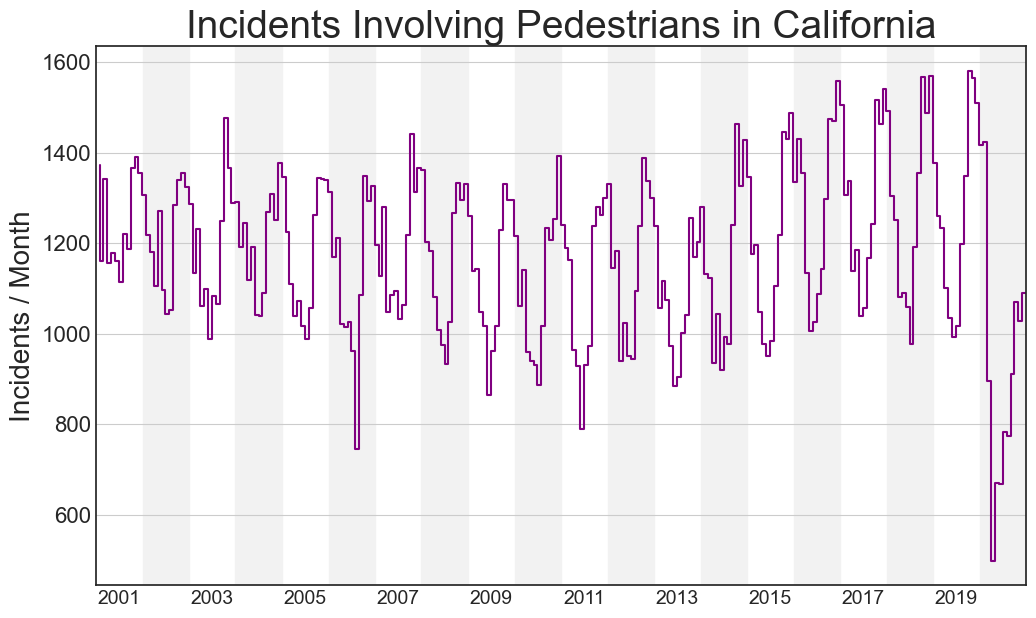

In [14]:
# Convert to a timeseries
fig, ax = setup_plot(
    title="Incidents Involving Pedestrians in California",
    xlabel="",
    ylabel="Incidents / Month",
)

ax.step(x, y, color=LINE_COLOR)

# Set Y range and grid
ax.grid()
ax.set_xlim((pd.Timestamp("2001-01-01"), pd.Timestamp(f"{LAST_YEAR}-12-31")))
# ax.set_ylim((75, 420))

# Set the year between the tick marks using minor ticks
# Pandas uses a obscure Axis labeling system, so to put the ticks between the
# major ticks, we interpolate it using np.interp().
y_lim = ax.get_xlim()
x_lim = (START_YEAR - 0.5, LAST_YEAR + 0.5)

minor_x = np.interp(np.arange(START_YEAR, LAST_YEAR + 1, 2), x_lim, y_lim)
minor_label = np.arange(START_YEAR, LAST_YEAR + 1, 2)

ax.set_xticks(minor_x, minor=True)
ax.set_xticklabels(minor_label, minor=True, size=14)
ax.set_xticks([])  # Unset major ticks

# Add shaded bands for every other year
for year in range(START_YEAR + 1, LAST_YEAR + 1, 2):
    ax.axvspan(
        pd.to_datetime(str(year)),
        pd.to_datetime(str(year + 1)),
        color="0.95",
        zorder=-1,
    )

for ext in ("png", "svg"):
    save_plot(fig, filename=f"/tmp/pedestrian_incidents_per_month_in_california.{ext}")

# Grouped by Day of the Year

In [15]:
from datetime import datetime


def annotate_year(
    df, ax, month, day, text, xytext_adjust, adjust=[0, 0], arrowstyle="->"
):
    """Draw an annotation on the Day of Year plot."""
    # Use 2016 because it is a leapyear, and we plot Feb 29
    doy = datetime(year=2016, month=month, day=day).timetuple().tm_yday
    y_pos = df[CRASH_COL][month][day]

    xy = (doy + adjust[0], y_pos + adjust[1])
    xytext = xy[0] + xytext_adjust[0], xy[1] + xytext_adjust[1]

    ax.annotate(
        text,
        xy,
        xytext=xytext,
        arrowprops=dict(
            arrowstyle=arrowstyle,
            connectionstyle="arc3",
        ),
        size=16,
        horizontalalignment="center",
    )

In [16]:
# Get the start locations of each month
def month_starts(df):
    """Get the start and midpoints of each month."""
    # Month starts
    majors = []
    for x, (month, day) in enumerate(df.index):
        if day == 1:
            majors.append(x)
        if month == 12 and day == 31:
            majors.append(x)

    # Midpoints
    minors = []
    for i in range(len(majors) - 1):
        end = majors[i + 1]
        start = majors[i]
        x = start + (end - start) / 2.0
        minors.append(x)

    return (majors, minors)

In [17]:
# Calculate crashes per day
NUMBER_OF_YEARS = (LAST_YEAR - START_YEAR) + 1
LEAP_YEAR_ADJUSTMENT = sum(
    1 for year in range(START_YEAR, LAST_YEAR + 1) if year % 4 == 0
)

mean_crashes = df.groupby(["month", "day"]).count()
mean_crashes[CRASH_COL] /= NUMBER_OF_YEARS  # Average instead of sum of years
mean_crashes[CRASH_COL][2][29] = mean_crashes[CRASH_COL][2][29] * LEAP_YEAR_ADJUSTMENT

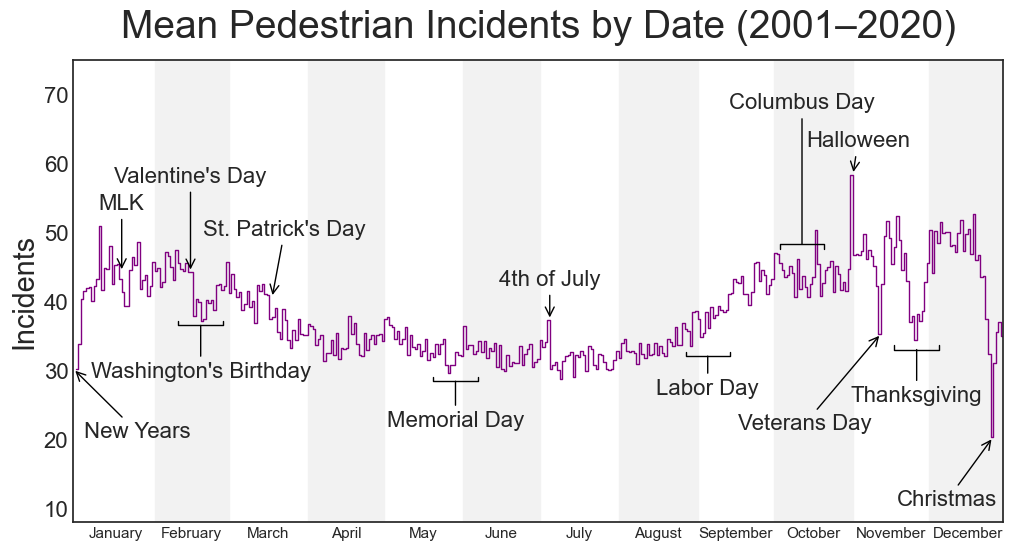

In [18]:
ax = mean_crashes[CRASH_COL].plot(
    drawstyle="steps-post",
    linewidth=1,
    figsize=(12, 6),
    color=LINE_COLOR,
)
fig = plt.gcf()

# Set Y Range and grid
ax.set_xlim([-1, 364])  # Avoid hiding the start/end points
ax.set_ylim([8, 75])

# Set axis labels
plt.title(
    f"Mean Pedestrian Incidents by Date ({START_YEAR}–{LAST_YEAR})",
    y=1.03,
    size=28,
)
FONTSIZE = "xx-large"
plt.xlabel("")
plt.ylabel("Incidents", fontsize=FONTSIZE)

# Fix the X tick labels
(major_x, minor_x) = month_starts(mean_crashes)
labels = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]
ax.set_xticks(major_x[:-1])
ax.set_xticklabels([])
ax.set_xticks(minor_x, minor=True)
ax.set_xticklabels(labels, minor=True, size=11)

# Shade every other month
for i in range(0, len(major_x) - 1, 2):
    start = major_x[i + 1]
    end = major_x[i + 2]
    ax.axvspan(start, end, color="0.95", zorder=-1)

# Federal Holidays
annotate_year(mean_crashes, ax, 1, 1, "New Years", (+25, -10), (-2, 0))
annotate_year(mean_crashes, ax, 1, 18, "MLK", (0, 9), (0, +1))
annotate_year(
    mean_crashes, ax, 2, 18, "Washington's Birthday", (0, -8), (0, -3), arrowstyle="-["
)
annotate_year(
    mean_crashes, ax, 5, 28, "Memorial Day", (0, -7), (0, -2), arrowstyle="-["
)
annotate_year(mean_crashes, ax, 7, 4, "4th of July", (0, +5))
annotate_year(mean_crashes, ax, 9, 4, "Labor Day", (0, -6), (0, -6), arrowstyle="-[")
annotate_year(
    mean_crashes, ax, 10, 11, "Columbus Day", (0, +20), (0, +6), arrowstyle="-["
)
annotate_year(mean_crashes, ax, 11, 11, "Veterans Day", (-30, -14))
annotate_year(
    mean_crashes, ax, 11, 25, "Thanksgiving", (0, -8), (0, -1), arrowstyle="-["
)
annotate_year(mean_crashes, ax, 12, 25, "Christmas", (-18, -10))

# Other Holidays
annotate_year(mean_crashes, ax, 10, 31, "Halloween", (2, 4))
annotate_year(mean_crashes, ax, 2, 14, "Valentine's Day", (0, 13))
annotate_year(mean_crashes, ax, 3, 17, "St. Patrick's Day", (+5, 9), (0, +3))

for ext in ("png", "svg"):
    save_plot(fig, filename=f"/tmp/mean_pedestrian_incidents_by_date.{ext}")

# Time of day

In [19]:
df_hour = df[["hour", "is_weekend", "crashes"]].groupby(["hour", "is_weekend"]).count()
df_hour = df_hour.reset_index()

# Normalize by number of days
weekend_count = df[df["is_weekend"] == True]["collision_date"].nunique()
weekday_count = df[df["is_weekend"] == False]["collision_date"].nunique()

df_hour.loc[df_hour["is_weekend"] == True, "crashes"] /= weekend_count
df_hour.loc[df_hour["is_weekend"] == False, "crashes"] /= weekday_count

x = df_hour["hour"].unique()
weekend_y = df_hour[df_hour["is_weekend"] == True]["crashes"].values
weekday_y = df_hour[df_hour["is_weekend"] == False]["crashes"].values

In [20]:
df_hour.head()

,hour,is_weekend,crashes
0,0.0,False,0.418471
1,0.0,True,1.019655
2,1.0,False,0.322859
3,1.0,True,1.062320
4,2.0,False,0.256754


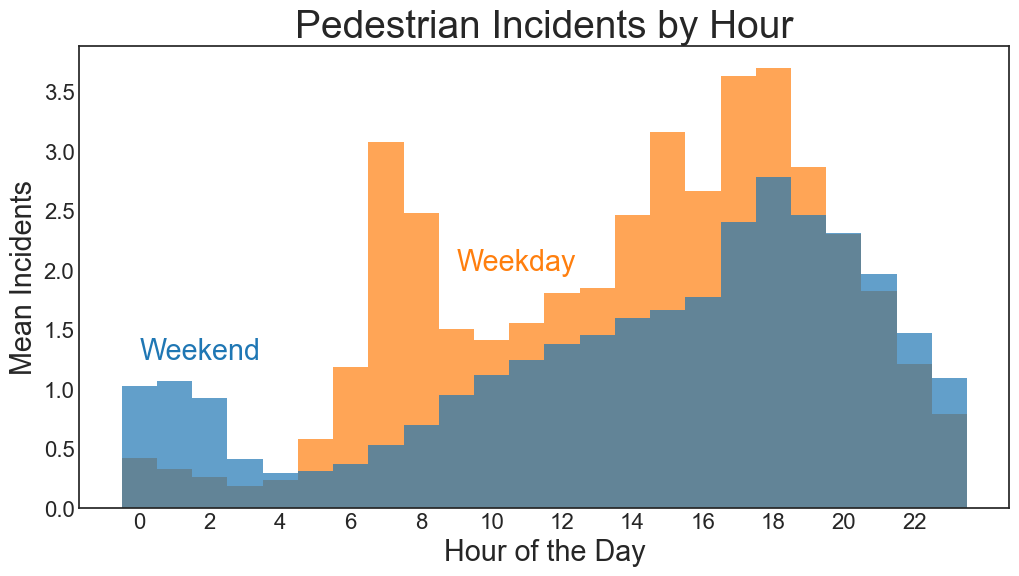

In [21]:
# halloween_df.hist(column="hour", bins=24)

# Set plotting style
plt.style.use("seaborn-v0_8-white")

# Set plot size
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(12, 6)

plt.hist(
    x=[x, x],
    bins=np.arange(0, 25, 1),
    weights=[weekend_y, weekday_y],
    histtype="stepfilled",
    align="left",
    alpha=0.7,
)

# Set plot title
plt.title("Pedestrian Incidents by Hour", size=28)
plt.ylabel("Mean Incidents", fontsize=FONTSIZE)
plt.xlabel("Hour of the Day", fontsize=FONTSIZE)

# Plot text
ax.text(
    0, 1.25, "Weekend", fontsize=FONTSIZE, color="C0"
)  # C0 is the first default color
ax.text(9, 2, "Weekday", fontsize=FONTSIZE, color="C1")

# Set X tick labels
ax.set_xticks(np.arange(0, 24, 2))

for ext in ("png", "svg"):
    plt.savefig(
        "/tmp/pedestrian_incidents_by_hour.{ext}".format(ext=ext),
        bbox_inches="tight",
    )